# 第8章: ニューラルネット

## 70.単語ベクトルの和による特徴量

In [1]:
import gensim
import numpy as np
import pandas as pd
import re

In [2]:
#configs
TRAIN_DATA_PATH ='./ch6_folder/save_data/train.csv'
VALID_DATA_PATH = './ch6_folder/save_data/valid.csv'
TEST_DATA_PATH = './ch6_folder/save_data/test.csv'
GOOGLE_MODEL_PATH = './ch7_folder/model/GoogleNews-vectors-negative300.bin'

In [3]:
model = gensim.models.KeyedVectors.load_word2vec_format(GOOGLE_MODEL_PATH, binary=True)

In [4]:
model_vocab_list = list(model.wv.vocab.keys())

/Users/yoshidatomoya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


記事の見出しの単語列 $(w_{i,1}, \ldots, w_{i,T_i})$ に対して、embeddingをおこない、以下のような特徴ベクトルを生成すると書いてあります。

$$
    {x}_i = \frac{1}{T_i}\sum_{1 \leq t \leq T_i} {emb}(w_{i,t}) 
$$

これは、各単語数に関する平均を特徴量にするということですね。

In [5]:
CATEGORY_TAG = {'b': 0, 't': 1, 'e': 2, 'm': 3}

In [6]:
df_train = pd.read_csv(TRAIN_DATA_PATH)
df_valid = pd.read_csv(VALID_DATA_PATH)
df_test = pd.read_csv(TEST_DATA_PATH)

In [7]:
train_titles_list = [title.split() for title in df_train['TITLE'].values.tolist()]
valid_titles_list = [title.split() for title in df_valid['TITLE'].values.tolist()]
test_titles_list = [title.split() for title in df_test['TITLE'].values.tolist()]

In [8]:
train_length = len(train_titles_list)
valid_length = len(valid_titles_list)
test_length = len(test_titles_list)
print(train_length, valid_length, test_length)

10672 1334 1334


In [9]:
def tokenize(word: str) -> str:
    """
    """
    word = word.replace('-', '')
    word = word.replace('.', '')
    word = word.replace('\'', '')
    word = word.replace(':', '')
    return word

In [10]:
def get_embedding_matrix(titles_list):
    feature_vecs_list = []
    
    for title in titles_list:
        tmp_vecs_list =[]
        for word in title:
            word = tokenize(word)
            try:
                vec = model[word]
                tmp_vecs_list.append(vec)
            except KeyError as e:
                pass
        
        if len(tmp_vecs_list) == 1:
            feature_vec = tmp_vecs_list[0]
        else:
            np_vecs = np.array(tmp_vecs_list)
            feature_vec = np.mean(np_vecs, axis=0)
        feature_vecs_list.append(feature_vec)
    return np.array(feature_vecs_list)

In [11]:
X_train = get_embedding_matrix(train_titles_list)
X_valid = get_embedding_matrix(valid_titles_list)
X_test = get_embedding_matrix(test_titles_list)

In [12]:
X_train.shape

(10672, 300)

In [13]:
X_valid.shape

(1334, 300)

In [14]:
X_test.shape

(1334, 300)

In [15]:
y_train= pd.read_csv(TRAIN_DATA_PATH)['CATEGORY'].map(CATEGORY_TAG).values
y_valid = pd.read_csv(VALID_DATA_PATH)['CATEGORY'].map(CATEGORY_TAG).values
y_test = pd.read_csv(TEST_DATA_PATH)['CATEGORY'].map(CATEGORY_TAG).values

In [16]:
Y_train = np.eye(4)[y_train]
Y_valid = np.eye(4)[y_valid]
Y_test = np.eye(4)[y_test]

In [17]:
y_train[1]

0

In [18]:
y_train.shape

(10672,)

In [19]:
Y_train.shape

(10672, 4)

In [20]:
y_valid.shape

(1334,)

In [21]:
Y_valid.shape

(1334, 4)

In [22]:
y_test.shape

(1334,)

In [23]:
Y_test.shape

(1334, 4)

## 71. 単層NNによる予測

個人的にこういう時にKerasを使うのが好きなのでKerasを使っていきます。
重みの初期化のところ、毎回同じ値を取りたいのでrandom seedみたいなことをしたいのですが、どうすればいいですかね。

In [24]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import tensorflow as tf

In [25]:
def predict_nn():
    inputs = Input(shape=(300,))
    outputs = Dense(4, activation='softmax') (inputs)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [26]:
x_1 = X_train[:1]
X_1_4 = X_train[:4]

In [27]:
model_71 = predict_nn()

In [28]:
model_71.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 1204      
Total params: 1,204
Trainable params: 1,204
Non-trainable params: 0
_________________________________________________________________


In [29]:
y_1 = model_71.predict(x_1)
Y_1_4 = model_71.predict(X_1_4)

In [30]:
y_1

array([[0.24893947, 0.22812319, 0.22335596, 0.2995814 ]], dtype=float32)

In [31]:
Y_1_4

array([[0.24893947, 0.22812319, 0.22335596, 0.2995814 ],
       [0.3085377 , 0.22342163, 0.22065622, 0.24738438],
       [0.2672257 , 0.2538322 , 0.2037863 , 0.27515572],
       [0.26254296, 0.27705783, 0.21813938, 0.24225996]], dtype=float32)

## 72. 損失と勾配の計算

文面からは、実際自分でクロスエントロピー損失関数や、勾配を`numpy`や`math`を用いて作成して、作成した関数を用いて求めてほしいのか、71とかで使ったモジュールを用いてやって欲しいのかイマイチわからないのですが、自作はせずにkerasを使ってやります。

In [32]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.backend import gradients

In [33]:
y_train_1 = Y_train[:1]
Y_train_1_4 = Y_train[:4]

In [34]:
CategoricalCrossentropy?

Init signature:
CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0,
    reduction='auto',
    name='categorical_crossentropy',
)
Docstring:     
Computes the crossentropy loss between the labels and predictions.

Use this crossentropy loss function when there are two or more label classes.
We expect labels to be provided in a `one_hot` representation. If you want to
provide labels as integers, please use `SparseCategoricalCrossentropy` loss.
There should be `# classes` floating point values per feature.

In the snippet below, there is `# classes` floating pointing values per
example. The shape of both `y_pred` and `y_true` are
`[batch_size, num_classes]`.

Usage:

```python
cce = tf.keras.losses.CategoricalCrossentropy()
loss = cce(
  [[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]],
  [[.9, .05, .05], [.05, .89, .06], [.05, .01, .94]])
print('Loss: ', loss.numpy())  # Loss: 0.0945
```

Usage with the `compile` API:

```python
model = tf.keras.Model(inputs, outputs)
model.

In [35]:
cce = CategoricalCrossentropy()

$\hat{y}_1$のクロスエントロピー損失は、

In [36]:
cce(y_train_1,y_1).numpy()

1.3905455

$\hat{Y}$のクロスエントロピー損失は、

In [37]:
cce(Y_train_1_4,Y_1_4).numpy()

1.2985538

損失を求められたので、次は勾配を求めます。実は、`keras`の関数である`keras.backend.gradient`を用いると`RuntimeError`がでます。
そのため、今回は`tf.GradientTape()`を用いて求めます。
ちなみに、先ほど定義したモデルから、weightの行列を取得し、そのweight行列と`numpy`の`gradient`を用いて計算して、gradientを求めようと思ったのですが、`numpy.gradient`の仕様がよくわからなくてやめました。誰か書ける人がいたら教えてください。

In [38]:
def calculate_grad(x,y):
    
    def _loss_fn(y_predict, y):
        return cce(y_predict, y)

    inputs = tf.convert_to_tensor(x)
    targets = tf.convert_to_tensor(y)
    with tf.GradientTape() as tape:
        y_predict = model_71(inputs)
        loss = _loss_fn(y_predict, targets)
    grads = tape.gradient(loss, model_71.variables)
    
    return grads

In [39]:
calculate_grad(x_1, y_train_1)

[<tf.Tensor: shape=(300, 4), dtype=float32, numpy=
 array([[ 0.05131765, -0.01558695, -0.01526122, -0.02046947],
        [-0.01723726,  0.00523555,  0.00512614,  0.00687556],
        [ 0.0138739 , -0.00421398, -0.00412592, -0.00553399],
        ...,
        [-0.20277433,  0.06158959,  0.06030252,  0.08088217],
        [-0.15681705,  0.04763078,  0.04663541,  0.06255084],
        [ 0.30664462, -0.0931386 , -0.09119222, -0.12231371]],
       dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-3.0135782 ,  0.91532815,  0.8962    ,  1.2020493 ], dtype=float32)>]

In [40]:
calculate_grad(x_1, y_train_1)[0].shape

TensorShape([300, 4])

In [41]:
calculate_grad(X_1_4, Y_train_1_4)

[<tf.Tensor: shape=(300, 4), dtype=float32, numpy=
 array([[-0.12147696,  0.05600534,  0.05011344,  0.01535821],
        [-0.12285115,  0.05578577,  0.05157541,  0.01549001],
        [ 0.02656722, -0.00102668, -0.00469257, -0.020848  ],
        ...,
        [-0.0824612 ,  0.00606671,  0.00522219,  0.07117223],
        [-0.17028889,  0.06984899,  0.06111809,  0.0393218 ],
        [ 0.09908519, -0.00365184, -0.00285049, -0.09258275]],
       dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-2.096949  ,  1.0811447 ,  0.9551051 ,  0.06069934], dtype=float32)>]

In [42]:
calculate_grad(X_1_4, Y_train_1_4)[0].shape

TensorShape([300, 4])

## 73. 確率的勾配降下法による学習

>確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ.

とのことなので、さっきのモデルを用いて、行いたいと思います。

In [43]:
from tensorflow.keras.optimizers import SGD

In [44]:
model_73 = predict_nn()

In [45]:
%%time
opt = SGD(learning_rate=0.01)
model_73.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_73.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid))

Train on 10672 samples, validate on 1334 samples
Epoch 1/100
10672/10672 [==============================] - 1s 57us/sample - loss: 1.2053 - accuracy: 0.5954 - val_loss: 1.0923 - val_accuracy: 0.7279
Epoch 2/100
10672/10672 [==============================] - 0s 28us/sample - loss: 1.0273 - accuracy: 0.7565 - val_loss: 0.9901 - val_accuracy: 0.7541
Epoch 3/100
10672/10672 [==============================] - 0s 29us/sample - loss: 0.9465 - accuracy: 0.7721 - val_loss: 0.9252 - val_accuracy: 0.7579
Epoch 4/100
10672/10672 [==============================] - 0s 28us/sample - loss: 0.8907 - accuracy: 0.7750 - val_loss: 0.8761 - val_accuracy: 0.7564
Epoch 5/100
10672/10672 [==============================] - 0s 28us/sample - loss: 0.8476 - accuracy: 0.7762 - val_loss: 0.8370 - val_accuracy: 0.7571
Epoch 6/100
10672/10672 [==============================] - 0s 25us/sample - loss: 0.8126 - accuracy: 0.7790 - val_loss: 0.8049 - val_accuracy: 0.7594
Epoch 7/100
10672/10672 [==========================

## 74.正解率の計測

In [46]:
score = model_73.evaluate(X_test, Y_test, verbose=0)

In [47]:
print('Test loss:{0}'.format(score[0]))
print('Test accuracy:{0}'.format(score[1]))

Test loss:0.41715731274062906
Test accuracy:0.8628185987472534


## 75. 損失と正解率のプロット

Kerasでは、`Callback`というクラスがあり、それを使うことによって、訓練中に関数を適用させることができます。

In [48]:
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

In [49]:
class RealTimePlot(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10,5))
        
        clear_output(wait=True)
        
#         ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="val_accuracy")
        ax2.legend()
        
        plt.show();

In [50]:
real_time_plot = RealTimePlot()

In [51]:
model_75 = predict_nn()

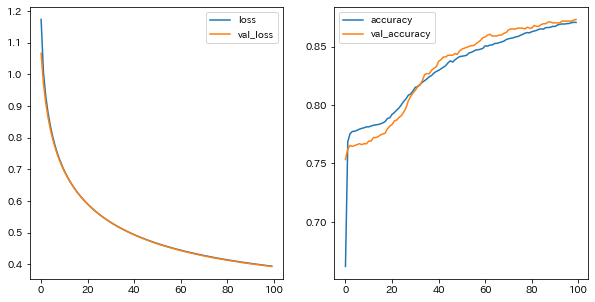

10672/10672 [==============================] - 1s 51us/sample - loss: 0.3943 - accuracy: 0.8707 - val_loss: 0.3934 - val_accuracy: 0.8733
CPU times: user 1min 5s, sys: 7.4 s, total: 1min 12s
Wall time: 57.4 s


In [52]:
%%time
opt = SGD(learning_rate=0.01)
model_75.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_75.fit(X_train, Y_train, epochs=100,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[real_time_plot])

lossもvalidation lossも同じように下がっているのが分かります。しかし奇妙な動きをしてますね。。。

## 76.チェックポイント

こちらも75と同様に、`Callbacks`を用います。

In [75]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

In [54]:
# configs
MODEL_DIR = './ch8_folder/models'

In [55]:
if not os.path.exists(MODEL_DIR):  # ディレクトリが存在しない場合、作成する。
    os.makedirs(MODEL_DIR)
checkpoint = ModelCheckpoint(filepath=os.path.join(MODEL_DIR, "model-{epoch:02d}.h5"), verbose=0,save_weights_only=True, save_freq=1)

In [56]:
model_76 = predict_nn()

先ほどまでエポックは100で行っていましたが、パラメータをたくさん出力したくないため、エポックを10で行います。

In [57]:
opt = SGD(learning_rate=0.01)
model_76.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_76.fit(X_train, Y_train, epochs=10,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[checkpoint])

Train on 10672 samples, validate on 1334 samples
Epoch 1/10
10672/10672 [==============================] - 2s 153us/sample - loss: 1.2061 - accuracy: 0.5631 - val_loss: 1.0915 - val_accuracy: 0.7181
Epoch 2/10
10672/10672 [==============================] - 1s 115us/sample - loss: 1.0297 - accuracy: 0.7468 - val_loss: 0.9887 - val_accuracy: 0.7489
Epoch 3/10
10672/10672 [==============================] - 1s 116us/sample - loss: 0.9483 - accuracy: 0.7637 - val_loss: 0.9230 - val_accuracy: 0.7549
Epoch 4/10
10672/10672 [==============================] - 1s 111us/sample - loss: 0.8915 - accuracy: 0.7684 - val_loss: 0.8735 - val_accuracy: 0.7556
Epoch 5/10
10672/10672 [==============================] - 1s 114us/sample - loss: 0.8475 - accuracy: 0.7721 - val_loss: 0.8341 - val_accuracy: 0.7586
Epoch 6/10
10672/10672 [==============================] - 1s 114us/sample - loss: 0.8120 - accuracy: 0.7736 - val_loss: 0.8014 - val_accuracy: 0.7609
Epoch 7/10
10672/10672 [===========================

これで`MODEL_DIR`内にモデルが生成されていると思います。

## 77.ミニバッチ化

kerasをもちいたミニバッチ化は簡単です。`model.fit`のオプション変数である、`batch_size`で変更が可能です。
問題ではBの値を1,2,4,8,...と書いてあるのですが、1,8,16あたりでやってみます。

In [58]:
model_77_1 = predict_nn()

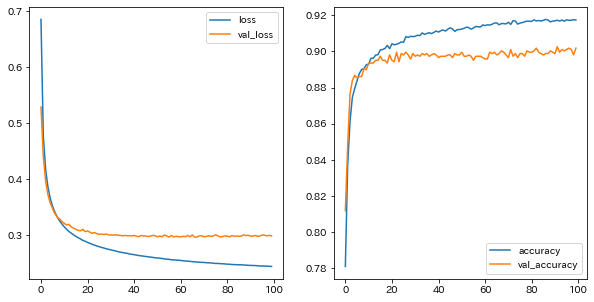

10672/10672 [==============================] - 8s 794us/sample - loss: 0.2448 - accuracy: 0.9174 - val_loss: 0.2992 - val_accuracy: 0.9018
CPU times: user 17min 5s, sys: 2min 19s, total: 19min 25s
Wall time: 13min 52s


In [59]:
%%time
opt = SGD(learning_rate=0.01)
model_77_1.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_77_1.fit(X_train, Y_train, epochs=100, batch_size=1,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[real_time_plot])

In [60]:
score1 = model_77_1.evaluate(X_test, Y_test, verbose=0)

In [61]:
print('Test loss:{0}'.format(score1[0]))
print('Test accuracy:{0}'.format(score1[1]))

Test loss:0.26944795778130126
Test accuracy:0.9070464968681335


In [62]:
model_77_8 = predict_nn()

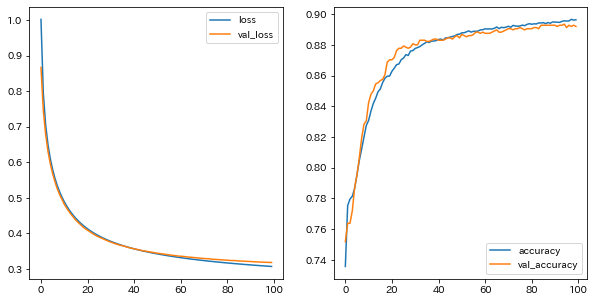

10672/10672 [==============================] - 1s 130us/sample - loss: 0.3069 - accuracy: 0.8964 - val_loss: 0.3180 - val_accuracy: 0.8921
CPU times: user 2min 44s, sys: 20.4 s, total: 3min 5s
Wall time: 2min 17s


In [63]:
%%time
opt = SGD(learning_rate=0.01)
model_77_8.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_77_8.fit(X_train, Y_train, epochs=100, batch_size=8,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[real_time_plot])

In [64]:
score2 = model_77_8.evaluate(X_test, Y_test, verbose=0)

In [65]:
print('Test loss:{0}'.format(score2[0]))
print('Test accuracy:{0}'.format(score2[1]))

Test loss:0.32343330000830195
Test accuracy:0.8898050785064697


In [66]:
model_77_16 = predict_nn()

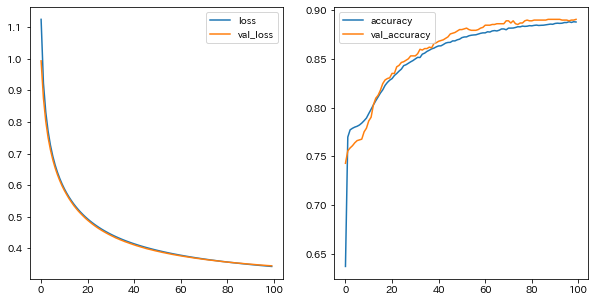

10672/10672 [==============================] - 1s 79us/sample - loss: 0.3429 - accuracy: 0.8878 - val_loss: 0.3449 - val_accuracy: 0.8906
CPU times: user 1min 38s, sys: 11.4 s, total: 1min 49s
Wall time: 1min 24s


In [67]:
%%time
opt = SGD(learning_rate=0.01)
model_77_16.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_77_16.fit(X_train, Y_train, epochs=100, batch_size=16,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[real_time_plot])

In [68]:
score3 = model_77_16.evaluate(X_test, Y_test, verbose=0)

In [69]:
print('Test loss:{0}'.format(score3[0]))
print('Test accuracy:{0}'.format(score3[1]))

Test loss:0.3617327741418464
Test accuracy:0.8785607218742371


## 78.GPU上での学習

こちらは手元の環境ではできないので行いません。

## 79.多層ニューラルネットワーク

先ほどまでは一層のニューラルネットワークをさわってたわけですが、今度は多層のニューラルネットとかを作ってみましょう。
今までの結果から、

- epochが100のままだと過適合しそう
- バッチサイズは小さいとよくなさそうなので、16ぐらいで

みたいが見えるので、そこら辺を意識しながらパラメータを編集します。

In [70]:
from tensorflow.keras.layers import Dropout

In [71]:
def many_nn():
    inputs = Input(shape=(300,))
    x = Dense(200, activation='relu')(inputs)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax') (x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [72]:
model_79 = many_nn()

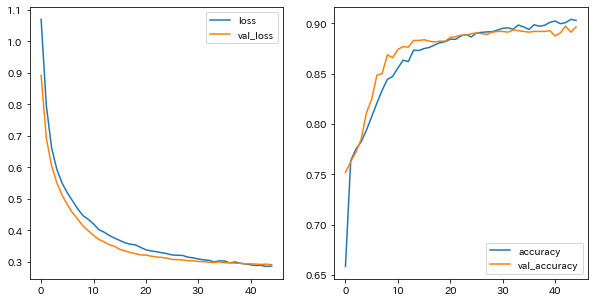

10672/10672 [==============================] - 1s 86us/sample - loss: 0.2870 - accuracy: 0.9030 - val_loss: 0.2910 - val_accuracy: 0.8966
CPU times: user 51.6 s, sys: 5.55 s, total: 57.2 s
Wall time: 43.1 s


In [73]:
%%time
opt = SGD(learning_rate=0.01)
model_79.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_79.fit(X_train, Y_train, epochs=45, batch_size=16,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[real_time_plot])

In [74]:
score4 = model_79.evaluate(X_test, Y_test, verbose=0)
print('Test loss:{0}'.format(score4[0]))
print('Test accuracy:{0}'.format(score4[1]))

Test loss:0.28149786564721163
Test accuracy:0.904047966003418


Accuracyそこまで上がらなかったですね。。。